# Dataset notes

If you have a dataset that doesn't fit into the standard Fast.ai formats, in general, I'd recommend thinking of a way to convert them over. It's going to mean you're working on solving the problem quicker and fighting against Fast.ai less.

If you have image data in a weird format, can you convert it into folder of images and a CSV with an image per line?

If you have time series data, can you join into a single entry per row?

If you have text data, can you munge it into a format similar to IMDB?

If not, let's quickly try to understand how the Fast.ai Datasets and Dataloaders work, and how they compare to PyTorch.

For some problems, you will need to create a custom dataset.

In this notebook, using the dataset from the [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge) Kaggle competition, which is in a [DICOM](https://en.wikipedia.org/wiki/DICOM) format, I'll show 3 examples:

1. Munging data into a Fast.ai friendly format.
2. Creating a custom Fast.ai Dataset.
3. Create a PyTorch dataset, then using a simple Fast.ai wrapper.

In [94]:
import pandas as pd
from pathlib import Path
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from fastai.imports import tqdm
from fastai.dataset import ImageClassifierData, BaseDataset, ModelData, get_cv_idxs
from fastai.dataloader import DataLoader
from fastai.transforms import tfms_from_model
from fastai.conv_learner import ConvLearner, ConvnetBuilder
from torchvision.models import resnet34
import torch

In [95]:
PATH = Path('./data/rsna-pneumonia')

In [96]:
# !kaggle competitions download -c rsna-pneumonia-detection-challenge --path {PATH}
# !unzip -qo {PATH}/stage_1_test_images.zip -d {PATH}/stage_1_test_images/
# !unzip -qo {PATH}/stage_1_train_labels.csv.zip -d {PATH}
# !chmod 777 {PATH}/stage_1_train_labels.csv
# !unzip -qo {PATH}/stage_1_train_images.zip -d {PATH}/stage_1_train_images/

## Example 1: converting a dataset into a Fast.ai friendly format

In [97]:
train_labels_df = pd.read_csv(PATH/'stage_1_train_labels.csv')

In [98]:
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Since you can have multiple rows representing the same patient, i'm going to flatten it keeping only the `Target` column.

In [99]:
train_target_df = train_labels_df.groupby('patientId').Target.mean().reset_index()

In [100]:
train_target_df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [101]:
idx = train_labels_df.iloc[0].patientId
img_arr = pydicom.dcmread(str(PATH/'stage_1_train_images'/f'{idx}.dcm'))

In [102]:
img_arr.pixel_array.shape

(1024, 1024)

Force a channel dimension by stacking the layers

In [103]:
img_arr = np.stack((img_arr.pixel_array,) * 3).transpose(1, 2, 0)

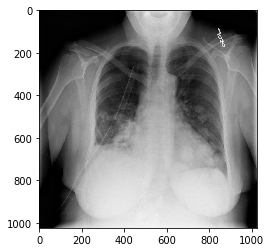

In [104]:
plt.imshow(img_arr)

In [105]:
train_path = PATH/'train'
train_path.mkdir(exist_ok=True)

def save_img(row):
    idx, row = row
    img_path = train_path / f'{row.patientId}.jpg'
    if img_path.exists():
        return

    dcm_img = pydicom.dcmread(str(PATH/'stage_1_train_images'/f'{row.patientId}.dcm'))
    img_arr = dcm_img.pixel_array
    img_arr = np.stack((img_arr,) * 3).transpose(1, 2, 0)
    plt.imsave(img_path, img_arr)
    
with Pool(8) as p:
    list(tqdm(
      p.imap(save_img, train_labels_df.iterrows()), total=len(train_labels_df)))

100%|██████████| 28989/28989 [00:05<00:00, 4903.47it/s]


In [106]:
train_target_df.to_csv(PATH/'train_target.csv', index=False)

In [107]:
size = 32

In [108]:
val_idxs = get_cv_idxs(len(train_target_df), seed=42)

In [109]:
data = ImageClassifierData.from_csv(
    PATH, 'train', PATH/'train_target.csv', val_idxs=val_idxs, tfms=tfms_from_model(resnet34, size), suffix='.jpg')

In [18]:
learner = ConvLearner.pretrained(resnet34, data, precompute=True)
learner.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.463463   0.440343   0.801207  



[array([0.44034]), 0.8012071651090342]

## Example 2: creating a Fast.ai dataset

All Fast.ai datasets inherit from `fastai.dataset.BaseDataset` which itself inherits from `torch.utils.data.Dataset`.

To build a Fast.ai dataset, you need to define 5 methods:

* `get_n` - number of elements in a dataset.
* `get_c` - number of classes in a dataset.
* `get_sz` - maximum size of an image in a dataset (if image content).
* `get_x` - get ith input example from the dataset.
* `get_y` - get ith target example from the dataset.

Let's look at how I could rebuild the `ImageClassifierData` loading the raw data from pydicom.

In [34]:
class PneumoniaDataset(BaseDataset):
    def __init__(self, df, transform=None):
        self.df = df
        super().__init__(transform)
        
    def get_n(self):
        return len(self.df)
    
    def get_c(self):
        # 2 classes 1 or 0
        return 2

    def get_sz(self):
        # All images are 1024x1024
        return 1024
    
    def get_x(self, i):
        row = self.df.iloc[i]
        dcm_img = pydicom.dcmread(str(PATH/'stage_1_train_images'/f'{row.patientId}.dcm'))
        img_arr = dcm_img.pixel_array
        img_arr = np.stack((img_arr,) * 3).transpose(1, 2, 0)
        return img_arr
    
    def get_y(self, i):
        row = self.df.iloc[i]
        return row.Target

In [35]:
trn_tfms, val_tfms = tfms_from_model(resnet34, size)
df = pd.read_csv(PATH/'train_target.csv')
train_df = df.iloc[val_idxs]
val_df = df.drop(val_idxs)

In [37]:
train_ds = PneumoniaDataset(train_df, transform=trn_tfms)
val_ds = PneumoniaDataset(val_df, transform=val_tfms)

In [38]:
X, y = train_ds[100]

In [39]:
X.shape, y

((3, 32, 32), 0)

In [45]:
batch_size = 16

In [46]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [47]:
X, y = next(iter(train_dl))

In [48]:
X.shape

torch.Size([16, 3, 32, 32])

In [49]:
y.shape

torch.Size([16])

In [50]:
data = ModelData.from_dls(PATH, train_dl, val_dl)

In [53]:
model = ConvnetBuilder(resnet34, c=train_ds.c, is_multi=False, is_reg=False, pretrained=True)
learner = ConvLearner(data, model)

In [54]:
learner.lr_find()

 74%|███████▍  | 238/321 [00:57<00:19,  4.16it/s, loss=2.56] 

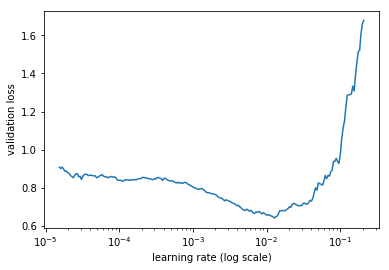

In [55]:
learner.sched.plot()

In [57]:
learner.fit(0.002, 1)

## Example 3: wrapping a PyTorch in a Fast.ai friendly format

The format for PyTorch is a bit simpler and less opinionate than Fast.ai. It only requires you to create 2 methods:

* `__len__ `- return the length of the Dataset.
* `__getitem__(self, idx)` - a single example.

In [134]:
class PneumoniaTorchDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dcm_img = pydicom.dcmread(str(PATH/'stage_1_train_images'/f'{row.patientId}.dcm'))
        img_arr = dcm_img.pixel_array
        img_arr = np.stack((img_arr,) * 3).transpose(1, 2, 0)
        
        # Convert to float
        img_arr = img_arr.astype(float) / 255
        
        return img_arr, row.Target

We can wrap it into a Fast.ai format as follows:

In [135]:
class TorchWrapperDataset(BaseDataset):
    def __init__(self, torch_ds, nb_classes, transform=None):
        self.torch_ds = torch_ds
        self.nb_classes = nb_classes
        super().__init__(transform)
        
    def __getitem__(self, idx):
        return self.get(self.transform, *self.torch_ds[idx])
    
    def get_c(self):
        return self.nb_classes
    
    def get_n(self):
        return len(self.torch_ds)
    
    def get_sz(self):
        x, _ = self[0]
        return x.shape[1]

In [136]:
train_torch_ds = PneumoniaTorchDataset(train_df)
val_torch_ds = PneumoniaTorchDataset(val_df)

In [137]:
train_ds = TorchWrapperDataset(train_torch_ds, 2, transform=trn_tfms)
val_ds = TorchWrapperDataset(val_torch_ds, 2, transform=val_tfms)

In [138]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

In [139]:
data = ModelData.from_dls(PATH, train_dl, val_dl)

In [140]:
model = ConvnetBuilder(resnet34, c=train_ds.c, is_multi=False, is_reg=False, pretrained=True)
learner = ConvLearner(data, model)

In [141]:
learner.lr_find()

 74%|███████▍  | 237/321 [01:46<00:37,  2.22it/s, loss=2.49] 

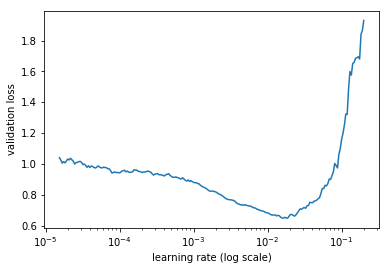

In [142]:
learner.sched.plot()

In [ ]:
learner.fit(0.002, 1)

 23%|██▎       | 73/321 [00:32<01:51,  2.22it/s, loss=0.65] 